## 通し課題：あるクラウドファンデイングが成功するか(state)を事前に予測するモデルを構築する<BR>（データソース：kaggle / ks-projects-201801）

### ライブラリのインポートと初期設定

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import SGDClassifier # ロジスティック回帰
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix ,precision_recall_fscore_support # モデルの評価、混同行列
from sklearn.model_selection import train_test_split # ホールドアウト法
from sklearn.model_selection import KFold # 交差検証法
from sklearn.preprocessing import StandardScaler, MinMaxScaler # 標準化
import nltk # 形態素解析
from nltk.corpus import stopwords
from sklearn.svm import SVC # SVM
from sklearn.model_selection import GridSearchCV # グリッドサーチ
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA #主成分分析用ライブラリ

# 全列を表示させる
# print(pd.get_option("display.max_columns"))
pd.set_option('display.max_columns', 100)
# print(pd.get_option("display.max_rows"))
pd.set_option('display.max_rows', 200)

## 1.データ理解

### データの読み込み

In [2]:
df = pd.read_csv("../ks-projects-201801.csv")

display(df.shape)
# display(df.dtypes)
display(df.info()) # "name"と"usd pledged"に欠損値あり
display(df.head())

(378661, 15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


None

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


### 変数の採用検討

|変数|説明|採否|備考|
|:--|:--|:--|:--|
|ID|---|不採用|---|
|name|---|採用|新しい説明変数に利用。欠損値あり|
|category|---|採用|ダミー変数化|
|main_category|---|採用|ダミー変数化|
|currency|---|採用|ダミー変数化|
|deadline|---|不採用|但し募集期間データとして利用|
|goal|Goal amount in project currency|不採用|usd_goal_realを利用|
|launched|---|不採用|但し募集期間データとして利用|
|pledged|Pledged amount in the project currency|不採用|予測時に分からないため|
|state|---|採用|successful,failedのみ利用|
|backers|"number of people who have pledged money to the project"|不採用|予測時に分からないため|
|country|---|不採用|currencyを利用|
|usd pledged|conversion in US dollars of the pledged column (conversion done by kickstarter) 米ドル換算 "not reliable enough"|不採用|予測時に分からないため。欠損値あり|
|usd_pledged_real|conversion in US dollars of the pledged column (conversion from Fixer.io API) 為替レート変換API使用|不採用|予測時に分からないため|
|usd_goal_real|---|採用|外れ値確認|

### データの可視化

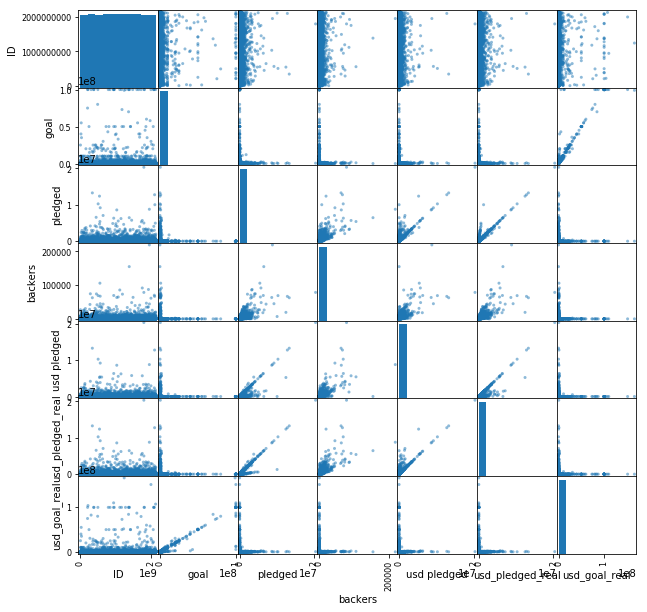

In [7]:
# 散布図行列
pd.plotting.scatter_matrix(df,figsize = (10,10))
plt.show()

## 2.前処理

### 欠損値の処理等

In [3]:
# "name"がnull、"state"が"canceled","undefined","live","suspended"、"country"が'N,0"'のデータを除外
#条件にマッチしたIndexを取得
drop_index = df.index[(df["name"].isnull()) | (df["state"] == "canceled") | (df["state"] == "undefined") | (df["state"] == "live") | (df["state"] == "suspended") | (df["country"] == 'N,0"')]
# display(drop_index)
#条件にマッチしたIndexを削除
df = df.drop(drop_index)

# "state"が"successful"のものを1、"failed"を0とする。
df.loc[df["state"]=="successful","state"] = 1
df.loc[df["state"]=="failed","state"] = 0

# display(df["state"].value_counts())
# print(df[df["country"] == 'N,0"'].count()) # 210

### 説明変数の追加（days）

In [4]:
# ローンチからデッドライン迄の期間("days")を算出
df["launched"] = pd.to_datetime(df["launched"])
df["launched_year"] = df["launched"].dt.strftime('%Y')
df["launched"] = df["launched"].dt.date # df[列名]で列名を指定すると、その列はpandas.Seriesとして取得される
df["deadline"] = pd.to_datetime(df["deadline"])
df["deadline"] = df["deadline"].dt.date
df["days"] = (df["deadline"] - df["launched"]).dt.days
# df["days"] = (df["deadline"] - df["launched"]) / datetime.timedelta(days=1)

### 説明変数の追加（name_freq）

In [5]:
# "successful"となったデータを抽出
df_success = df[df["state"] == 1]
df_success.head()

# "name"を纏める
word = ' '.join(df_success["name"])
# print(word[0:500])

# tokenize
tokens = nltk.word_tokenize(word)
# print(tokens_l[0:500])
tokens_l = [w.lower() for w in tokens]
text = nltk.Text(tokens_l)

# stopwords設定
stop_words = set(stopwords.words('english'))
filtered_sentence = [w for w in text if not w in stop_words]
filtered_sentence = []
for w in text:
    if w not in stop_words:
        filtered_sentence.append(w)

pos = nltk.pos_tag(filtered_sentence)

# 名詞だけ抽出
only_nn = [x for (x,y) in pos if y in ('NN')]
freq = nltk.FreqDist(only_nn)

In [6]:
top = freq.most_common(50)
labels, values = zip(*top)
print(labels)

# nameがtop50を含んでいたら"name_freq"を1とする
pattern = '|'.join(labels)
# print(pattern)
df["name_freq"] = df["name"].str.contains(pattern)
df["name_freq"] = df["name_freq"] * 1
# df.head(50)

('film', 'album', 'project', 'book', 'game', 'music', 'debut', 'art', 'world', 'help', 'record', 'cd', 'series', 'life', 'video', 'ep', 'story', 'studio', 'edition', 'dance', 'tour', 'show', 'city', 'man', 'card', 'collection', 'time', 'feature', 'festival', 'release', 'season', 'magazine', 'adventure', 'space', 'home', 'day', 'love', 'issue', 'food', 'volume', 'playing', 'movie', 'length', 'board', 'company', 'novel', 'comedy', 'fund', 'rpg', 'horror')


### 説明変数の追加（name_len）

In [7]:
df["name_len"]=df["name"].str.len()

### カテゴリカルデータのダミー変数化

In [8]:
df_dummy = pd.get_dummies(df[["main_category","category","currency","country"]])
df2 = pd.concat([df,df_dummy],axis=1)
df2 = df2.drop(["ID","name","backers","main_category","category","country","currency","deadline","launched","launched_year","usd_pledged_real","pledged","usd pledged","goal"],axis=1)
df2.info()
display(df2.head())
display(df2.describe())
# display(df2.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331462 entries, 0 to 378660
Columns: 215 entries, state to country_US
dtypes: float64(1), int32(1), int64(3), uint8(210)
memory usage: 80.3 MB


,state,usd_goal_real,days,name_freq,name_len,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,category_Art Books,category_Audio,category_Bacon,category_Blues,category_Calendars,category_Camera Equipment,category_Candles,category_Ceramics,category_Children's Books,category_Childrenswear,category_Chiptune,category_Civic Design,category_Classical Music,category_Comedy,category_Comic Books,category_Comics,category_Community Gardens,category_Conceptual Art,category_Cookbooks,...,category_Vegan,category_Video,category_Video Art,category_Video Games,category_Wearables,category_Weaving,category_Web,category_Webcomics,category_Webseries,category_Woodworking,category_Workshops,category_World Music,category_Young Adult,category_Zines,currency_AUD,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD,country_AT,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_HK,country_IE,country_IT,country_JP,country_LU,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,0,1533.95,59,0,31,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,30000.00,60,1,45,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,45000.00,45,0,14,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,5000.00,30,0,49,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,1,50000.00,35,0,20,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


,state,usd_goal_real,days,name_freq,name_len,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,category_Art Books,category_Audio,category_Bacon,category_Blues,category_Calendars,category_Camera Equipment,category_Candles,category_Ceramics,category_Children's Books,category_Childrenswear,category_Chiptune,category_Civic Design,category_Classical Music,category_Comedy,category_Comic Books,category_Comics,category_Community Gardens,category_Conceptual Art,category_Cookbooks,...,category_Vegan,category_Video,category_Video Art,category_Video Games,category_Wearables,category_Weaving,category_Web,category_Webcomics,category_Webseries,category_Woodworking,category_Workshops,category_World Music,category_Young Adult,category_Zines,currency_AUD,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD,country_AT,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_HK,country_IE,country_IT,country_JP,country_LU,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
count,331462.000000,3.314620e+05,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,...,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000,331462.000000
mean,0.403820,4.152286e+04,33.955910,0.174608,34.220840,0.077354,0.029801,0.023586,0.010780,0.076519,0.059657,0.170466,0.066536,0.086043,0.012514,0.138179,0.029231,0.106839,0.081596,0.030899,0.001714,0.002344,0.008266,0.001874,0.000691,0.006676,0.002223,0.018599,0.015951,0.001937,0.022585,0.007449,0.001095,0.000546,0.000706,0.000875,0.001056,0.001140,0.000830,0.018699,0.001261,0.000100,0.000803,0.007361,0.006239,0.007521,0.013821,0.000818,0.002806,0.001373,...,0.001593,0.001162,0.000525,0.028139,0.002917,0.000247,0.013000,0.001807,0.015531,0.003192,0.000447,0.005853,0.002142,0.001071,0.019960,0.037320,0.001967,0.002794,0.043314,0.088858,0.001439,0.000069,0.004257,0.001756,0.003844,0.004553,0.001370,0.788501,0.001463,0.019960,0.001578,0.037320,0.001967,0.010366,0.002794,0.005651,0.007603,0.088858,0.001439,0.002061,0.007147,0.000069,0.000172,0.004257,0.007274,0.001756,0.003844,0.004553,0.001370,0.788501
std,0.490663,1.109279e+06,12.714067,0

### 外れ値への対処（学習で除外しても最終テストでは除外せず全て使う）

19.33848395848824


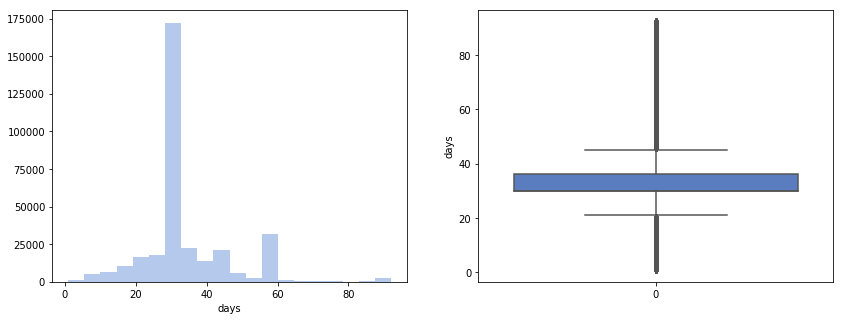

In [9]:
# "days" →　maxの92日も異常とは言えないためそのままとする。
sns.set_palette('muted')
fig, ax = plt.subplots(1, 2,figsize = (14,5))

# ヒストグラム
sns.distplot(
    df2["days"], bins=20, label='data', ax=ax[0],
    kde=False,
    rug=False
)
# スタージェスの公式を参考に適当なbinsの値を求める
print(np.log2((len(df2["days"]))) + 1) 

# 箱ひげ図
sns.boxplot(data=df2["days"],ax=ax[1])
ax[1].set_ylabel("days")

plt.show()

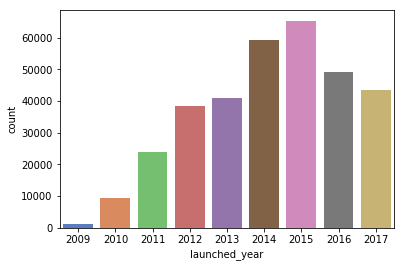

In [10]:
# "launched"に1Jan70データがある？　→　大丈夫そう。
sns.countplot(x="launched_year", data=df)

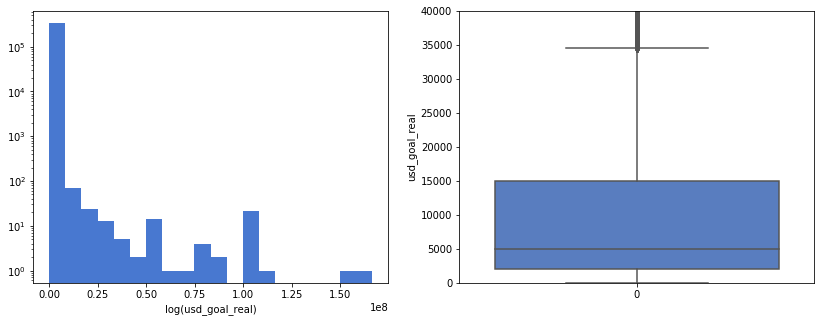

In [11]:
# "usd_goal_real"
sns.set_palette('muted')
fig, ax = plt.subplots(1, 2,figsize = (14,5))

# ヒストグラム
ax[0].hist(df2["usd_goal_real"],log=True, bins=20)
ax[0].set_xlabel("log(usd_goal_real)")

# スタージェスの公式を参考に適当なbinsの値を求める
# print(np.log2((len(df2["usd_goal_real"]))) + 1) 

# 箱ひげ図
sns.boxplot(data=df2["usd_goal_real"],ax=ax[1])
ax[1].set_ylabel("usd_goal_real")
ax[1].set(ylim=(0,40000)) 
plt.show()

# "usd_goal_real"はlogを取ることにする。
df2["log_usd_goal_real"] = np.log(df2["usd_goal_real"])
df2 = df2.drop("usd_goal_real",axis=1)

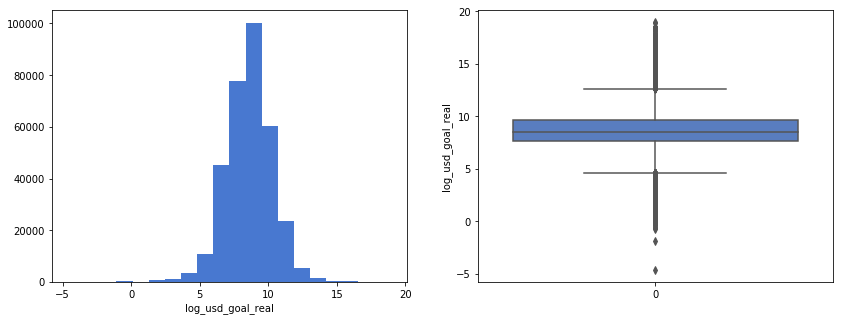

,state,days,name_freq,name_len,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,category_Art Books,category_Audio,category_Bacon,category_Blues,category_Calendars,category_Camera Equipment,category_Candles,category_Ceramics,category_Children's Books,category_Childrenswear,category_Chiptune,category_Civic Design,category_Classical Music,category_Comedy,category_Comic Books,category_Comics,category_Community Gardens,category_Conceptual Art,category_Cookbooks,category_Country & Folk,...,category_Video,category_Video Art,category_Video Games,category_Wearables,category_Weaving,category_Web,category_Webcomics,category_Webseries,category_Woodworking,category_Workshops,category_World Music,category_Young Adult,category_Zines,currency_AUD,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD,country_AT,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_HK,country_IE,country_IT,country_JP,country_LU,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US,log_usd_goal_real
0,0,59,0,31,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,7.335601
1,0,60,1,45,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10.308953
2,0,45,0,14,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10.714418
3,0,30,0,49,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8.517193
5,1,35,0,20,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10.819778


In [12]:
fig, ax = plt.subplots(1, 2,figsize = (14,5))

# ヒストグラム
ax[0].hist(df2["log_usd_goal_real"],log=False, bins=20)
ax[0].set_xlabel("log_usd_goal_real")

# 箱ひげ図
sns.boxplot(data=df2["log_usd_goal_real"],ax=ax[1])
ax[1].set_ylabel("log_usd_goal_real")
plt.show()

df2.head()

### データの標準化

### 特徴選択（フィルタ法）

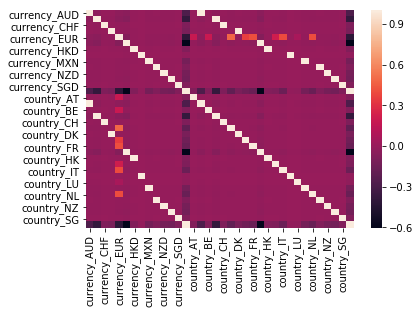

,state,days,name_freq,name_len,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,category_Art Books,category_Audio,category_Bacon,category_Blues,category_Calendars,category_Camera Equipment,category_Candles,category_Ceramics,category_Children's Books,category_Childrenswear,category_Chiptune,category_Civic Design,category_Classical Music,category_Comedy,category_Comic Books,category_Comics,category_Community Gardens,category_Conceptual Art,category_Cookbooks,category_Country & Folk,...,category_Robots,category_Rock,category_Romance,category_Science Fiction,category_Sculpture,category_Shorts,category_Small Batch,category_Software,category_Sound,category_Space Exploration,category_Spaces,category_Stationery,category_Tabletop Games,category_Taxidermy,category_Technology,category_Television,category_Textiles,category_Theater,category_Thrillers,category_Translations,category_Typography,category_Vegan,category_Video,category_Video Art,category_Video Games,category_Wearables,category_Weaving,category_Web,category_Webcomics,category_Webseries,category_Woodworking,category_Workshops,category_World Music,category_Young Adult,category_Zines,currency_AUD,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD,log_usd_goal_real
0,0,59,0,31,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,7.335601
1,0,60,1,45,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10.308953
2,0,45,0,14,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10.714418
3,0,30,0,49,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8.517193
5,1,35,0,20,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10.819778


In [13]:
# display(df2[["currency_AUD","currency_CAD","currency_CHF","currency_DKK","currency_EUR","currency_GBP","currency_HKD","currency_JPY","currency_MXN","currency_NOK","currency_NZD","currency_SEK","currency_SGD","currency_USD","country_AT","country_AU","country_BE","country_CA","country_CH","country_DE","country_DK","country_ES","country_FR","country_GB","country_HK","country_IE","country_IT","country_JP","country_LU","country_MX","country_NL","country_NO","country_NZ","country_SE","country_SG","country_US"]].corr())
sns.heatmap(df2[["currency_AUD","currency_CAD","currency_CHF","currency_DKK","currency_EUR","currency_GBP","currency_HKD","currency_JPY","currency_MXN","currency_NOK","currency_NZD","currency_SEK","currency_SGD","currency_USD","country_AT","country_AU","country_BE","country_CA","country_CH","country_DE","country_DK","country_ES","country_FR","country_GB","country_HK","country_IE","country_IT","country_JP","country_LU","country_MX","country_NL","country_NO","country_NZ","country_SE","country_SG","country_US"]].corr())
plt.show()

# scatter_matrixはPCパワー上、描画できず
# pd.plotting.scatter_matrix(df2[["currency_AUD","currency_CAD","currency_CHF","currency_DKK","currency_EUR","currency_GBP","currency_HKD","currency_JPY","currency_MXN","currency_NOK","currency_NZD","currency_SEK","currency_SGD","currency_USD","country_AT","country_AU","country_BE","country_CA","country_CH","country_DE","country_DK","country_ES","country_FR","country_GB","country_HK","country_IE","country_IT","country_JP","country_LU","country_MX","country_NL","country_NO","country_NZ","country_SE","country_SG","country_US"]] ,figsize = (10,10))
# plt.show()

# currencyとcountryは強い相関があるためをcountryを削除する
df2 = df2.drop(["country_AT","country_AU","country_BE","country_CA","country_CH","country_DE","country_DK","country_ES","country_FR","country_GB","country_HK","country_IE","country_IT","country_JP","country_LU","country_MX","country_NL","country_NO","country_NZ","country_SE","country_SG","country_US"] ,axis=1)
df2.head()

In [14]:
df22 = df2.drop("state", axis=1)
df2_columns_list = df22.columns.values.tolist()
# df2_columns_list

### 特徴選択（埋め込み法）

In [29]:
estimator = LassoCV(normalize=True, cv=10)
sfm = SelectFromModel(estimator, threshold=1e-5)

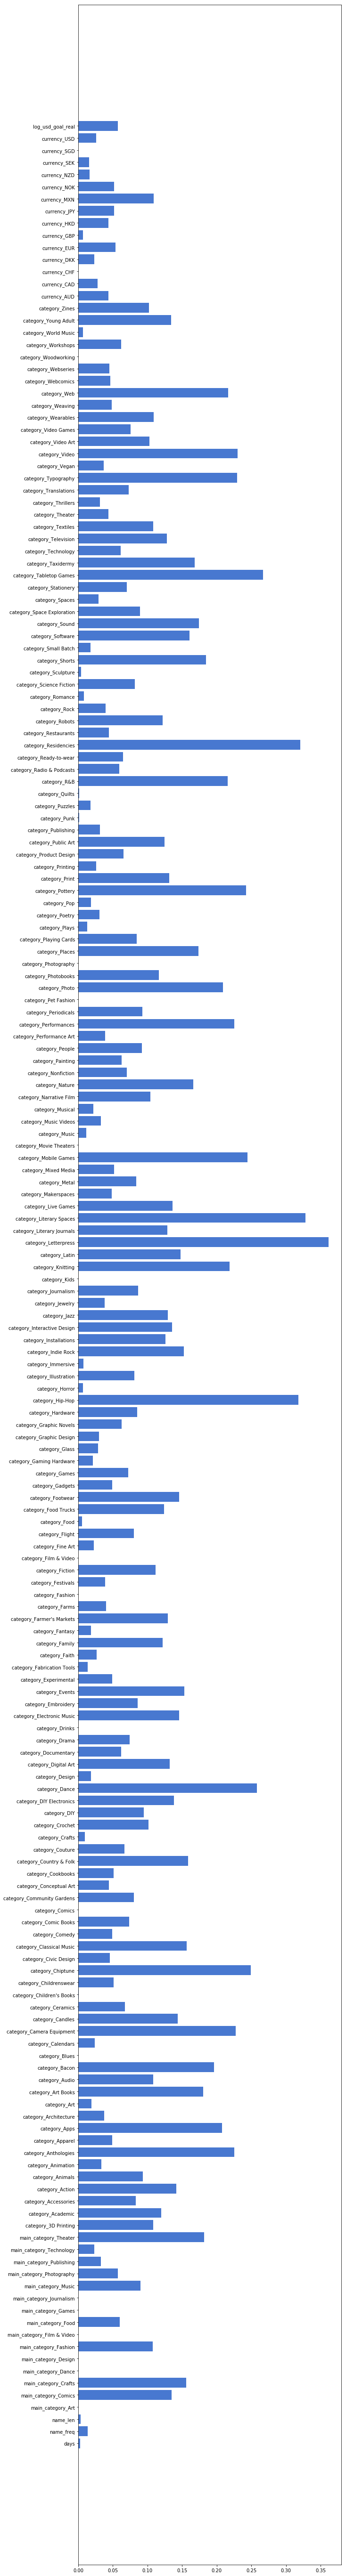

In [28]:
# 全データでやるべきではない？

train_label = df2["state"]
train_data = df2.drop("state", axis=1)

y = train_label.values
X = train_data.values

sfm.fit(X, y)
sfm.get_support()

removed_idx  = ~sfm.get_support()
train_data.columns[removed_idx]

abs_coef = np.abs(sfm.estimator_.coef_)
abs_coef

plt.figure(figsize=(10, 100))
plt.barh(np.arange(0, len(abs_coef)), abs_coef, tick_label=train_data.columns.values)
plt.show()

### 特徴選択（PCA）

### データ分割

In [15]:
y = df2["state"].values # この時点でnumpy.ndarray
X = df2.drop(["state"],axis=1).values
display(y.shape)
display(X.shape)
display(type(y))

# scikit-learn の各メソッドは numpy.ndarray に対する処理を前提にしている。
# pandas のデータ形式 (DataFrame や Series) を渡すと 内部で ndarray に変換して結果を返してくる。

(331462,)

(331462, 192)

numpy.ndarray

In [16]:
# ホールドアウト
test_size = 0.25
X_train, X_final_test, y_train, y_final_test = train_test_split(X, y, test_size=test_size, random_state=1234)
display(X_train.shape)
display(y_train.shape)
display(X_final_test.shape)
display(y_final_test.shape)
print(type(X_train))

(248596, 192)

(248596,)

(82866, 192)

(82866,)

<class 'numpy.ndarray'>


## 3.モデル検討

### 3-1.ロジスティック回帰

In [18]:
# クロスバリデーション（ロジスティック回帰 & L1正則化）
n_split = 7 # グループ数を設定
cross_valid_accuracy = 0
cross_valid_precision = 0
cross_valid_recall = 0
cross_valid_f1_score = 0
split_num = 1

for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X_train, y_train): # 返ってくるのはインデックス
    X_train_CV, y_train_CV = X[train_idx], y[train_idx] # CV学習用データ ; numpy.ndarray object
    X_test_CV, y_test_CV = X[test_idx], y[test_idx]     # CVテスト用データ

#     print(train_idx)
#     print(test_idx)

    X_train_CV = pd.DataFrame(X_train_CV)
#     y_train_CV = pd.DataFrame(y_train_CV)
#     X_test_CV = pd.DataFrame(X_test_CV)
#     y_test_CV = pd.DataFrame(y_test_CV)
    X_train_CV.columns = df2_columns_list
    
#     print(type(X_train_CV))
#     X_train_CV.head()

    # グループ毎に標準化
    stdsc = StandardScaler()
    X_train_CV["log_usd_goal_real"] = stdsc.fit_transform(X_train_CV[["log_usd_goal_real"]].values)
    X_train_CV["days"] = stdsc.fit_transform(X_train_CV[["days"]].values)
    X_train_CV["name_len"] = stdsc.fit_transform(X_train_CV[["name_len"]].values)
    
    X_train_CV = X_train_CV.values
    
#     display(X_train_CV.shape)
#     display(y_train_CV.shape)
#     display(X_test_CV.shape)
#     display(y_test_CV.shape)

    # ロジスティック回帰 & L1正則化
    clf = SGDClassifier(loss='log', penalty='l1', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
    clf.fit(X_train_CV, y_train_CV)

    # テストデータに対する予測を実行
    y_pred_test_CV = clf.predict(X_test_CV)

#     print("Fold %s"%split_num) # %sは文字列として値を該当箇所に挿入するための記号。直後の %(変数名) は%s の場所に挿入する変数を表す

    accuracy =  accuracy_score(y_test_CV, y_pred_test_CV)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_CV, y_pred_test_CV)
    
#     print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
#     print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
#     print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
#     print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))
#     print('')
    
    cross_valid_accuracy += accuracy # 後で平均を取るために加算
    cross_valid_precision += precision
    cross_valid_recall += recall
    cross_valid_f1_score += f1_score
    split_num += 1

# 平均値を最終的な誤差値とする
final_accuracy = cross_valid_accuracy / n_split
final_precision = cross_valid_precision / n_split
final_recall = cross_valid_recall / n_split
final_f1_score = cross_valid_f1_score / n_split

print('平均 正答率（Accuracy） = {:.3f}%'.format(100 * final_accuracy))
print('平均 適合率（Precision） = {:.3f}%'.format(100 * final_precision[1]))
print('平均 再現率（Recall） = {:.3f}%'.format(100 * final_recall[1]))
print('平均 F1値（F1-score） = {:.3f}%'.format(100 * final_f1_score[1]))

平均 正答率（Accuracy） = 60.144%
平均 適合率（Precision） = 53.490%
平均 再現率（Recall） = 38.027%
平均 F1値（F1-score） = 40.979%


In [19]:
## 全学習データを用いたモデル構築
X_train = pd.DataFrame(X_train)
X_train.columns = df2_columns_list
    
# 標準化
stdsc = StandardScaler()
X_train["log_usd_goal_real"] = stdsc.fit_transform(X_train[["log_usd_goal_real"]].values)
X_train["days"] = stdsc.fit_transform(X_train[["days"]].values)
X_train["name_len"] = stdsc.fit_transform(X_train[["name_len"]].values)
X_train = X_train.values

# ロジスティック回帰 & L1正則化
clf_final = SGDClassifier(loss='log', penalty='l1', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf_final.fit(X_train, y_train)

# ファイナルテストデータに対する予測を実行
y_pred_final_test = clf_final.predict(X_final_test)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_final_test,y_pred_final_test)))

#予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_final_test,y_pred_final_test), 
                        index=['実際：Negative','実際：Positive'],
                        columns=['予測:Negative','予測:Positive'])
display(conf_mat)

accuracy =  accuracy_score(y_final_test,y_pred_final_test)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_final_test,y_pred_final_test)

print('汎化誤差')
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

対数尤度 = -13.336


,予測:Negative,予測:Positive
実際：Negative,41026,8622
実際：Positive,23374,9844


汎化誤差
正答率（Accuracy） = 61.388%
適合率（Precision） = 53.309%
再現率（Recall） = 29.635%
F1値（F1-score） = 38.093%


### 3-2.SVM（後回し）

In [ ]:
# # SVMの学習実行
# C = 5
# kernel = "rbf"
# gamma = 1
# clf_SVM = SVC(C=C, kernel=kernel, gamma=gamma)
# # SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, 
# # class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
# # gamma は、例えばガウスカーネルのスケールパラメータ（正規分布の標準偏差に対応するもの）を指定する
# clf_SVM.fit(Xh_train, yh_train)

# # 未知のデータを識別する
# yh_pred_test = clf_SVM.predict(Xh_test)

### 3-3.決定木

In [26]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.externals.six import StringIO
import pydotplus

# クロスバリデーション
n_split = 7 # グループ数を設定
cross_valid_accuracy = 0
cross_valid_precision = 0
cross_valid_recall = 0
cross_valid_f1_score = 0
split_num = 1

for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X_train, y_train): # 返ってくるのはインデックス
    X_train_CV, y_train_CV = X[train_idx], y[train_idx] # CV学習用データ ; numpy.ndarray object
    X_test_CV, y_test_CV = X[test_idx], y[test_idx]     # CVテスト用データ

#     X_train_CV = pd.DataFrame(X_train_CV)
#     X_train_CV.columns = df2_columns_list
    
#     # グループ毎に標準化
#     stdsc = StandardScaler()
#     X_train_CV["log_usd_goal_real"] = stdsc.fit_transform(X_train_CV[["log_usd_goal_real"]].values)
#     X_train_CV["days"] = stdsc.fit_transform(X_train_CV[["days"]].values)
#     X_train_CV["name_len"] = stdsc.fit_transform(X_train_CV[["name_len"]].values)
    
#     X_train_CV = X_train_CV.values
    
    # 決定木
    clf_tree = DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_split=3, min_samples_leaf=3, random_state=1234)
    clf_tree = clf_tree.fit(X_train_CV, y_train_CV)

    print("score=", clf_tree.score(X_train_CV, y_train_CV)) # score関数の返り値はaccuracy
    
    # テストデータに対する予測を実行
    y_pred_test_CV = clf_tree.predict(X_test_CV)

    # 決定木の描画
#     dot_data = StringIO() # dotファイル情報の格納先；グラフ構造を記述するためのファイル形式で，
#                           # sklearn から自動生成可能．graphviz は dot ファイルを可視化するツール．
#     export_graphviz(clf, out_file=dot_data,  
# #                      feature_names=["x1", "x2"],  
# #                      class_names=["0","1"],  
#                      filled=True, rounded=True,  
#                      special_characters=True) 
#     graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
#     Image(graph.create_png())
    
#     print("Fold %s"%split_num) # %sは文字列として値を該当箇所に挿入するための記号。直後の %(変数名) は%s の場所に挿入する変数を表す

    accuracy =  accuracy_score(y_test_CV, y_pred_test_CV)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_CV, y_pred_test_CV)
    
#     print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
#     print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
#     print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
#     print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))
#     print('')
    
    cross_valid_accuracy += accuracy # 後で平均を取るために加算
    cross_valid_precision += precision
    cross_valid_recall += recall
    cross_valid_f1_score += f1_score
    split_num += 1

# 平均値を最終的な誤差値とする
final_accuracy = cross_valid_accuracy / n_split
final_precision = cross_valid_precision / n_split
final_recall = cross_valid_recall / n_split
final_f1_score = cross_valid_f1_score / n_split

print('平均 正答率（Accuracy） = {:.3f}%'.format(100 * final_accuracy))
print('平均 適合率（Precision） = {:.3f}%'.format(100 * final_precision[1]))
print('平均 再現率（Recall） = {:.3f}%'.format(100 * final_recall[1]))
print('平均 F1値（F1-score） = {:.3f}%'.format(100 * final_f1_score[1]))

score= 0.8477675261167062
score= 0.8483776198834252
score= 0.8478050703485044
score= 0.8477065167400344
score= 0.8479646333336462
score= 0.8471675356551203
score= 0.8470830615300141
平均 正答率（Accuracy） = 61.922%
平均 適合率（Precision） = 53.217%
平均 再現率（Recall） = 48.772%
平均 F1値（F1-score） = 50.897%


In [28]:
# ## 全学習データを用いたモデル構築
# X_train = pd.DataFrame(X_train)
# X_train.columns = df2_columns_list
    
# # 標準化
# stdsc = StandardScaler()
# X_train["log_usd_goal_real"] = stdsc.fit_transform(X_train[["log_usd_goal_real"]].values)
# X_train["days"] = stdsc.fit_transform(X_train[["days"]].values)
# X_train["name_len"] = stdsc.fit_transform(X_train[["name_len"]].values)
# X_train = X_train.values

# 決定木
clf_tree_final = DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_split=3, min_samples_leaf=3, random_state=1234)
clf_tree_final = clf_tree_final.fit(X_train, y_train)

# ファイナルテストデータに対する予測を実行
y_pred_final_test = clf_tree_final.predict(X_final_test)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_final_test,y_pred_final_test)))

#予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_final_test,y_pred_final_test), 
                        index=['実際：Negative','実際：Positive'],
                        columns=['予測:Negative','予測:Positive'])
display(conf_mat)

accuracy =  accuracy_score(y_final_test,y_pred_final_test)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_final_test,y_pred_final_test)

print('汎化誤差')
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

対数尤度 = -13.829


,予測:Negative,予測:Positive
実際：Negative,49639,9
実際：Positive,33170,48


汎化誤差
正答率（Accuracy） = 59.961%
適合率（Precision） = 84.211%
再現率（Recall） = 0.144%
F1値（F1-score） = 0.289%


### 3-4.ランダムフォレスト

In [33]:
from sklearn.ensemble import RandomForestClassifier

# クロスバリデーション
n_split = 7 # グループ数を設定
cross_valid_accuracy = 0
cross_valid_precision = 0
cross_valid_recall = 0
cross_valid_f1_score = 0
split_num = 1

for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X_train, y_train): # 返ってくるのはインデックス
    X_train_CV, y_train_CV = X[train_idx], y[train_idx] # CV学習用データ ; numpy.ndarray object
    X_test_CV, y_test_CV = X[test_idx], y[test_idx]     # CVテスト用データ

    # ランダムフォレスト
    clf_RF = RandomForestClassifier(n_estimators=100, max_depth=3, criterion="gini",
                                                 min_samples_leaf=2, min_samples_split=3, random_state=1234)
    clf_RF.fit(X_train_CV, y_train_CV)
    print("score=", clf_RF.score(X_train_CV, y_train_CV))

    # 説明変数の重要度を出力する
    # scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
#     print(clf_RF.feature_importances_)
    
    # テストデータに対する予測を実行
    y_pred_test_CV = clf_RF.predict(X_test_CV)

    accuracy =  accuracy_score(y_test_CV, y_pred_test_CV)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_CV, y_pred_test_CV)
    
    cross_valid_accuracy += accuracy # 後で平均を取るために加算
    cross_valid_precision += precision
    cross_valid_recall += recall
    cross_valid_f1_score += f1_score
    split_num += 1

# 平均値を最終的な誤差値とする
final_accuracy = cross_valid_accuracy / n_split
final_precision = cross_valid_precision / n_split
final_recall = cross_valid_recall / n_split
final_f1_score = cross_valid_f1_score / n_split

print('平均 正答率（Accuracy） = {:.3f}%'.format(100 * final_accuracy))
print('平均 適合率（Precision） = {:.3f}%'.format(100 * final_precision[1]))
print('平均 再現率（Recall） = {:.3f}%'.format(100 * final_recall[1]))
print('平均 F1値（F1-score） = {:.3f}%'.format(100 * final_f1_score[1]))

score= 0.5988774274692372
score= 0.5988868135271868
score= 0.5978543471527393
score= 0.5985583014989535
score= 0.5983001849053416
score= 0.5989590910584138
score= 0.5979923316266431
平均 正答率（Accuracy） = 59.844%
平均 適合率（Precision） = 79.499%
平均 再現率（Recall） = 1.028%
平均 F1値（F1-score） = 2.030%


In [30]:
## 全学習データを用いたモデル構築

# ランダムフォレスト
clf_RF_final = RandomForestClassifier(n_estimators=100, max_depth=3, criterion="gini",
                                                 min_samples_leaf=2, min_samples_split=3, random_state=1234)
clf_RF_final.fit(X_train, y_train)

# ファイナルテストデータに対する予測を実行
y_pred_final_test = clf_RF_final.predict(X_final_test)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_final_test,y_pred_final_test)))

#予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_final_test,y_pred_final_test), 
                        index=['実際：Negative','実際：Positive'],
                        columns=['予測:Negative','予測:Positive'])
display(conf_mat)

accuracy =  accuracy_score(y_final_test,y_pred_final_test)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_final_test,y_pred_final_test)

print('汎化誤差')
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

対数尤度 = -13.845


,予測:Negative,予測:Positive
実際：Negative,49648,0
実際：Positive,33218,0


汎化誤差
正答率（Accuracy） = 59.914%
適合率（Precision） = 0.000%
再現率（Recall） = 0.000%
F1値（F1-score） = 0.000%


C:\Users\bb101\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 3-5.アダブースト

In [31]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# クロスバリデーション
n_split = 7 # グループ数を設定
cross_valid_accuracy = 0
cross_valid_precision = 0
cross_valid_recall = 0
cross_valid_f1_score = 0
split_num = 1

for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X_train, y_train): # 返ってくるのはインデックス
    X_train_CV, y_train_CV = X[train_idx], y[train_idx] # CV学習用データ ; numpy.ndarray object
    X_test_CV, y_test_CV = X[test_idx], y[test_idx]     # CVテスト用データ

    
    # 下記は決定木の例
    clf_ABC = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4,
                                                                                 min_samples_leaf=3,
                                                                                 min_samples_split=6, 
                                                                                 random_state=1234,
                                                                                 criterion="entropy"),
                                           n_estimators=8, random_state=1234)
    clf_ABC.fit(X_train_CV, y_train_CV)
    print("score=", clf_ABC.score(X_train_CV, y_train_CV))
    
    # テストデータに対する予測を実行
    y_pred_test_CV = clf_ABC.predict(X_test_CV)

    accuracy =  accuracy_score(y_test_CV, y_pred_test_CV)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_CV, y_pred_test_CV)
    
    cross_valid_accuracy += accuracy # 後で平均を取るために加算
    cross_valid_precision += precision
    cross_valid_recall += recall
    cross_valid_f1_score += f1_score
    split_num += 1

# 平均値を最終的な誤差値とする
final_accuracy = cross_valid_accuracy / n_split
final_precision = cross_valid_precision / n_split
final_recall = cross_valid_recall / n_split
final_f1_score = cross_valid_f1_score / n_split

print('平均 正答率（Accuracy） = {:.3f}%'.format(100 * final_accuracy))
print('平均 適合率（Precision） = {:.3f}%'.format(100 * final_precision[1]))
print('平均 再現率（Recall） = {:.3f}%'.format(100 * final_recall[1]))
print('平均 F1値（F1-score） = {:.3f}%'.format(100 * final_f1_score[1]))

score= 0.6759088050609624
score= 0.678762166677617
score= 0.6784946640260557
score= 0.6766784618128232
score= 0.6776593048685483
score= 0.6772525260109911
score= 0.6757460707799309
平均 正答率（Accuracy） = 67.496%
平均 適合率（Precision） = 62.070%
平均 再現率（Recall） = 50.623%
平均 F1値（F1-score） = 55.754%


In [32]:
## 全学習データを用いたモデル構築

# アダブースト
clf_ABC_final = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4,
                                                                                 min_samples_leaf=3,
                                                                                 min_samples_split=6, 
                                                                                 random_state=1234,
                                                                                 criterion="entropy"),
                                           n_estimators=8, random_state=1234)
clf_ABC_final.fit(X_train, y_train)

# ファイナルテストデータに対する予測を実行
y_pred_final_test = clf_ABC_final.predict(X_final_test)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_final_test,y_pred_final_test)))

#予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_final_test,y_pred_final_test), 
                        index=['実際：Negative','実際：Positive'],
                        columns=['予測:Negative','予測:Positive'])
display(conf_mat)

accuracy =  accuracy_score(y_final_test,y_pred_final_test)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_final_test,y_pred_final_test)

print('汎化誤差')
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))

対数尤度 = -13.841


,予測:Negative,予測:Positive
実際：Negative,49648,0
実際：Positive,33207,11


汎化誤差
正答率（Accuracy） = 59.927%
適合率（Precision） = 100.000%
再現率（Recall） = 0.033%


### 3-6.ニューラルネットワーク

In [17]:
from tensorflow import keras  
import tensorflow as tf
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

model = Sequential()
model.add(Dense(6, activation='relu', input_dim=192)) # 1層目
model.add(Dense(5, activation='relu', input_dim=6)) # 2層目
model.add(Dense(2, activation='softmax'))#最終層のactivationは変更しないこと  # 3層目

# 第一引数の「6」は，ユニットの個数です．ここを増やすほど，モデルの複雑さが増します．
# 「input_dim=4」は，入力の次元数です．一層目だけ指定すれば問題ありません．
# あとはmodel.addとすることで層を深くすることができます.
# 最後の層は，回帰問題なら model.add(Dense(1, activation='linear'))
# 分類問題なら，model.add(Dense(3, activation='softmax')) ※ Denseの第一引数はクラス数
# と指定します．


# ------ 最適化手法 ------
# sgd = SGD(lr=0.01, momentum=0.9, nesterov=False) # 最急降下法に近い
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
adam = Adam(lr=0.01) # 実務でよく使う。計算が早い、収束する
# -----------------------------

model.compile(loss='sparse_categorical_crossentropy', # 元はcategorical_crossentropy
              optimizer=adam, # 最初は Adam に対して学習率をいくつか試し，他のパラメータはいじらない，くらいの戦略が手軽
              metrics=['accuracy'])

# WARNINGが出るが気にしなくて良い

# 損失関数などを設定する部分 model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])の引数について，
# 分類問題なら loss='categorical_crossentropy' #交差エントロピー ,metrics=['accuracy'] #精度
# 回帰問題なら loss='mean_squared_error' #二乗誤差 ,metrics=['mae'] #絶対値誤差
# を指定します．
# optimizer=sgdの部分はnotebookを真似していくつか変えてみてください，学習が早く終わるのはadamです．

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 213082 samples, validate on 35514 samples
Epoch 1/50
213082/213082 [==============================] - 2s 8us/sample - loss: 0.5907 - acc: 0.6736 - val_loss: 0.5900 - val_acc: 0.6784
Epoch 2/50
213082/213082 [==============================] - 2s 7us/sample - loss: 0.5899 - acc: 0.6780 - val_loss: 0.5896 - val_acc: 0.6785
Epoch 3/50
213082/213082 [==============================] - 2s 7us/sample - loss: 0.5896 - acc: 0.6780 - val_loss: 0.5893 - val_acc: 0.6785
Epoch 4/50
213082/213082 [==============================] - 2s 7us/sample - loss: 0.5895 - acc: 0.6781 - val_loss: 0.5891 - val_acc: 0.6779
Epoch 5/50
213082/213082 [==============================] - 1s 7us/sample - loss: 0.5893 - acc: 0.6780 - val_loss: 0.5892 - val_acc: 0.6779
Epoch 6/50
213082/213082 [==============================] - 2s 7us/sample - loss: 0.5893 - acc: 0.6781 - val_loss: 0.5890 - val_acc: 0.6779
Epoch 7/50
213082/213082 [==============================] - 2s 7us/sample - loss: 0.5892 - acc: 0.6781 - val_

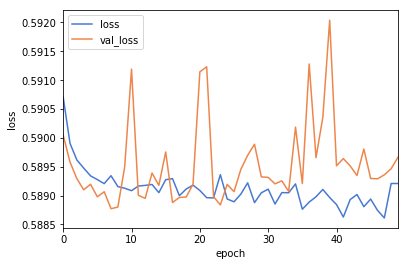

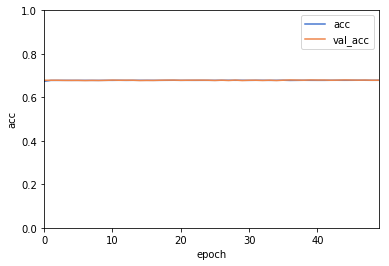

Train on 213082 samples, validate on 35514 samples
Epoch 1/50
213082/213082 [==============================] - 2s 7us/sample - loss: 0.5887 - acc: 0.6789 - val_loss: 0.5901 - val_acc: 0.6781
Epoch 2/50
213082/213082 [==============================] - 2s 7us/sample - loss: 0.5886 - acc: 0.6785 - val_loss: 0.5901 - val_acc: 0.6780
Epoch 3/50
213082/213082 [==============================] - 1s 7us/sample - loss: 0.5885 - acc: 0.6787 - val_loss: 0.5905 - val_acc: 0.6780
Epoch 4/50
213082/213082 [==============================] - 2s 7us/sample - loss: 0.5889 - acc: 0.6791 - val_loss: 0.5905 - val_acc: 0.6771
Epoch 5/50
213082/213082 [==============================] - 2s 7us/sample - loss: 0.5888 - acc: 0.6784 - val_loss: 0.5902 - val_acc: 0.6781
Epoch 6/50
213082/213082 [==============================] - 1s 7us/sample - loss: 0.5886 - acc: 0.6788 - val_loss: 0.5901 - val_acc: 0.6775
Epoch 7/50
213082/213082 [==============================] - 2s 7us/sample - loss: 0.5886 - acc: 0.6784 - val_

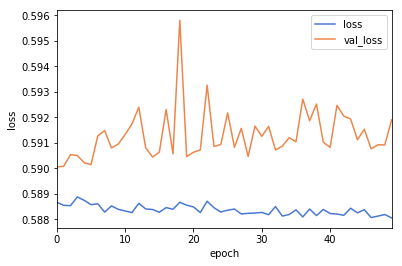

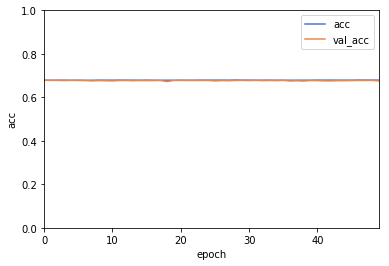

Train on 213082 samples, validate on 35514 samples
Epoch 1/50
213082/213082 [==============================] - 1s 7us/sample - loss: 0.5890 - acc: 0.6788 - val_loss: 0.5861 - val_acc: 0.6804
Epoch 2/50
213082/213082 [==============================] - 1s 7us/sample - loss: 0.5888 - acc: 0.6789 - val_loss: 0.5886 - val_acc: 0.6796
Epoch 3/50
213082/213082 [==============================] - 1s 7us/sample - loss: 0.5892 - acc: 0.6783 - val_loss: 0.5859 - val_acc: 0.6793
Epoch 4/50
213082/213082 [==============================] - 1s 7us/sample - loss: 0.5888 - acc: 0.6787 - val_loss: 0.5872 - val_acc: 0.6799
Epoch 5/50
213082/213082 [==============================] - 1s 7us/sample - loss: 0.5888 - acc: 0.6788 - val_loss: 0.5866 - val_acc: 0.6799
Epoch 6/50
213082/213082 [==============================] - 1s 7us/sample - loss: 0.5886 - acc: 0.6787 - val_loss: 0.5863 - val_acc: 0.6804
Epoch 7/50
213082/213082 [==============================] - 1s 7us/sample - loss: 0.5890 - acc: 0.6781 - val_

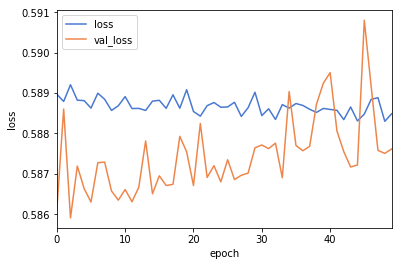

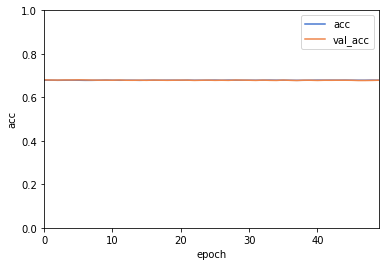

Train on 213082 samples, validate on 35514 samples
Epoch 1/50
213082/213082 [==============================] - 1s 7us/sample - loss: 0.5884 - acc: 0.6789 - val_loss: 0.5878 - val_acc: 0.6788
Epoch 2/50
213082/213082 [==============================] - 2s 7us/sample - loss: 0.5883 - acc: 0.6786 - val_loss: 0.5884 - val_acc: 0.6793
Epoch 3/50
213082/213082 [==============================] - 2s 7us/sample - loss: 0.5883 - acc: 0.6787 - val_loss: 0.5887 - val_acc: 0.6780
Epoch 4/50
213082/213082 [==============================] - 1s 7us/sample - loss: 0.5886 - acc: 0.6789 - val_loss: 0.5881 - val_acc: 0.6766
Epoch 5/50
213082/213082 [==============================] - 2s 7us/sample - loss: 0.5882 - acc: 0.6791 - val_loss: 0.5879 - val_acc: 0.6783
Epoch 6/50
213082/213082 [==============================] - 7s 34us/sample - loss: 0.5883 - acc: 0.6792 - val_loss: 0.5886 - val_acc: 0.6776
Epoch 7/50
213082/213082 [==============================] - 5s 23us/sample - loss: 0.5886 - acc: 0.6788 - va

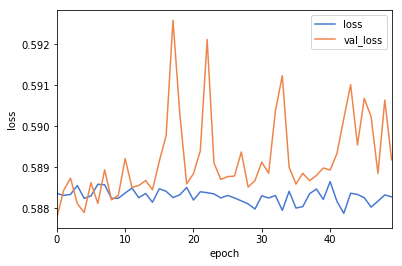

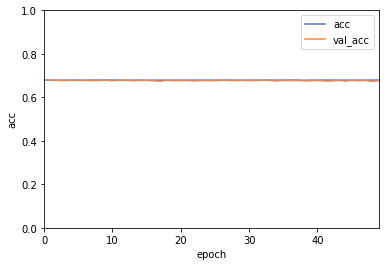

Train on 213082 samples, validate on 35514 samples
Epoch 1/50
213082/213082 [==============================] - 1s 7us/sample - loss: 0.5884 - acc: 0.6789 - val_loss: 0.5867 - val_acc: 0.6786
Epoch 2/50
213082/213082 [==============================] - 1s 7us/sample - loss: 0.5890 - acc: 0.6785 - val_loss: 0.5869 - val_acc: 0.6781
Epoch 3/50
213082/213082 [==============================] - 1s 7us/sample - loss: 0.5885 - acc: 0.6783 - val_loss: 0.5860 - val_acc: 0.6787
Epoch 4/50
213082/213082 [==============================] - 1s 7us/sample - loss: 0.5887 - acc: 0.6789 - val_loss: 0.5868 - val_acc: 0.6795
Epoch 5/50
213082/213082 [==============================] - 2s 7us/sample - loss: 0.5886 - acc: 0.6791 - val_loss: 0.5869 - val_acc: 0.6770
Epoch 6/50
213082/213082 [==============================] - 1s 7us/sample - loss: 0.5885 - acc: 0.6788 - val_loss: 0.5879 - val_acc: 0.6786
Epoch 7/50
213082/213082 [==============================] - 1s 7us/sample - loss: 0.5884 - acc: 0.6787 - val_

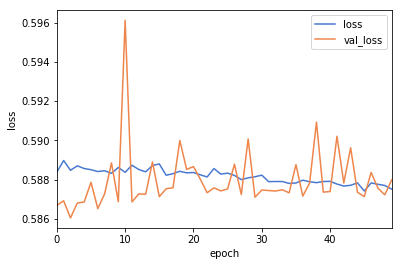

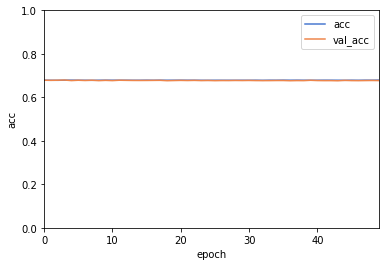

Train on 213083 samples, validate on 35513 samples
Epoch 1/50
213083/213083 [==============================] - 2s 7us/sample - loss: 0.5878 - acc: 0.6786 - val_loss: 0.5877 - val_acc: 0.6783
Epoch 2/50
213083/213083 [==============================] - 1s 7us/sample - loss: 0.5874 - acc: 0.6791 - val_loss: 0.5880 - val_acc: 0.6781
Epoch 3/50
213083/213083 [==============================] - 1s 7us/sample - loss: 0.5872 - acc: 0.6792 - val_loss: 0.5885 - val_acc: 0.6777
Epoch 4/50
213083/213083 [==============================] - 2s 7us/sample - loss: 0.5874 - acc: 0.6788 - val_loss: 0.5880 - val_acc: 0.6774
Epoch 5/50
213083/213083 [==============================] - 1s 7us/sample - loss: 0.5877 - acc: 0.6789 - val_loss: 0.5880 - val_acc: 0.6770
Epoch 6/50
213083/213083 [==============================] - 1s 7us/sample - loss: 0.5876 - acc: 0.6788 - val_loss: 0.5882 - val_acc: 0.6783
Epoch 7/50
213083/213083 [==============================] - 1s 7us/sample - loss: 0.5872 - acc: 0.6787 - val_

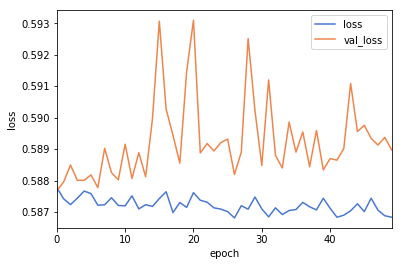

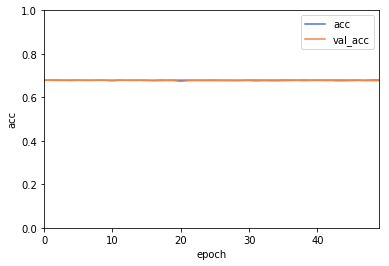

Train on 213083 samples, validate on 35513 samples
Epoch 1/50
213083/213083 [==============================] - 1s 7us/sample - loss: 0.5871 - acc: 0.6784 - val_loss: 0.5884 - val_acc: 0.6779
Epoch 2/50
213083/213083 [==============================] - 1s 7us/sample - loss: 0.5873 - acc: 0.6784 - val_loss: 0.5876 - val_acc: 0.6798
Epoch 3/50
213083/213083 [==============================] - 1s 7us/sample - loss: 0.5871 - acc: 0.6786 - val_loss: 0.5877 - val_acc: 0.6803
Epoch 4/50
213083/213083 [==============================] - 1s 7us/sample - loss: 0.5874 - acc: 0.6791 - val_loss: 0.5881 - val_acc: 0.6792
Epoch 5/50
213083/213083 [==============================] - 1s 7us/sample - loss: 0.5870 - acc: 0.6785 - val_loss: 0.5936 - val_acc: 0.6775
Epoch 6/50
213083/213083 [==============================] - 1s 7us/sample - loss: 0.5871 - acc: 0.6786 - val_loss: 0.5879 - val_acc: 0.6796
Epoch 7/50
213083/213083 [==============================] - 2s 7us/sample - loss: 0.5870 - acc: 0.6786 - val_

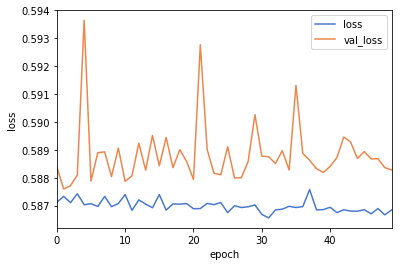

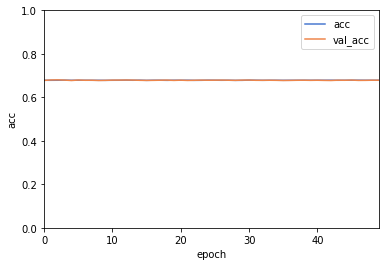

In [21]:
# クロスバリデーション
n_split = 7 # グループ数を設定
cross_valid_accuracy = 0
cross_valid_precision = 0
cross_valid_recall = 0
cross_valid_f1_score = 0
split_num = 1

for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X_train, y_train): # 返ってくるのはインデックス
    X_train_CV, y_train_CV = X[train_idx], y[train_idx] # CV学習用データ ; numpy.ndarray object
    X_test_CV, y_test_CV = X[test_idx], y[test_idx]     # CVテスト用データ

    
    # 計算の実行
    fit = model.fit(X_train_CV, y_train_CV,
          epochs=50, # epoch : 学習データを何回見るか
          batch_size=1000,validation_data=(X_test_CV, y_test_CV)) # batch_size : ランダムに抽出するデータ数

    # テストデータに対する予測を実行
#     y_pred_test_CV = fit.predict(X_test_CV)
    
    # 各epochにおける損失と精度をdfに入れる
    df = pd.DataFrame(fit.history)

    # グラフ化
    df[["loss", "val_loss"]].plot() # loss:訓練誤差、val_loss:テスト誤差 ※過学習をチェック（lossが下がってval_lossが上がる）
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.show()

    df[["acc", "val_acc"]].plot()
    plt.ylabel("acc") # 確率値が最大となったクラスと正解クラスがどれだけ一致していたかを測る指標
    plt.xlabel("epoch")
    plt.ylim([0,1.0])
    plt.show()
    
#     accuracy =  accuracy_score(y_test_CV, y_pred_test_CV)
#     precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_CV, y_pred_test_CV)
    
#     cross_valid_accuracy += accuracy # 後で平均を取るために加算
#     cross_valid_precision += precision
#     cross_valid_recall += recall
#     cross_valid_f1_score += f1_score
#     split_num += 1

# # 平均値を最終的な誤差値とする
# final_accuracy = cross_valid_accuracy / n_split
# final_precision = cross_valid_precision / n_split
# final_recall = cross_valid_recall / n_split
# final_f1_score = cross_valid_f1_score / n_split

# print('平均 正答率（Accuracy） = {:.3f}%'.format(100 * final_accuracy))
# print('平均 適合率（Precision） = {:.3f}%'.format(100 * final_precision[1]))
# print('平均 再現率（Recall） = {:.3f}%'.format(100 * final_recall[1]))
# print('平均 F1値（F1-score） = {:.3f}%'.format(100 * final_f1_score[1]))

### 3-7.モデルの比較

## 4.ハイパーパラメータ最適化

In [ ]:
parameters = {'kernel':['linear', 'rbf'], 'C':[1, 5]} # ここを編集する
model = SVC(gamma="scale") # gamma=scaleにすると、gammaが自動で計算される
clf_SVM2 = GridSearchCV(model, parameters, cv=3,)
clf_SVM2.fit(Xh_train, yh_train)
print(clf_SVM2.best_params_, clf_SVM2.best_score_)